In [38]:
import pandas as pd
import os
import random
import shutil
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import logging
from datetime import datetime

Finding Number of faces in FAKE and REAL labelled folders

In [7]:
face_path = "faces"
fake_images_dir = os.path.join(face_path, "FAKE")
real_images_dir = os.path.join(face_path,"REAL")
print("No. of Deep-Faked Faces",len(os.listdir(fake_images_dir)))
print("No. of Real Faces",len(os.listdir(real_images_dir)))

No. of Deep-Faked Faces 9810
No. of Real Faces 1201


There are 9x more fake images than real images, so we need to balance the dataset. We will follow a mixed approach to balance the dataset.

1. Remove the 3rd frame from the fake videos to reduce the number of fake images. (approximately 3x reduction in fake images)
2. Randomly select n number of fake images to balance the dataset. (where n is variable and model is trained on different values of n to find the best value)

We are moving all the unused images to a separate folder called `unused_images` for future use.

In [8]:
os.listdir(fake_images_dir)[:10]

['aakbpusmxs.mp4_0.jpg',
 'aakbpusmxs.mp4_1.jpg',
 'aakbpusmxs.mp4_2.jpg',
 'aanzliuzft.mp4_0.jpg',
 'aanzliuzft.mp4_1.jpg',
 'aanzliuzft.mp4_2.jpg',
 'aatfilvfmc.mp4_0.jpg',
 'aatfilvfmc.mp4_1.jpg',
 'aatfxhkzqx.mp4_0.jpg',
 'aatfxhkzqx.mp4_1.jpg']

In [11]:
unused_folder = os.path.join(face_path, "unused_images")

if not os.path.exists(unused_folder):
    os.mkdir(unused_folder)

fake_images = glob.glob(os.path.join(fake_images_dir, "*_2.j*"))

for file_path in fake_images:
    filename = os.path.basename(file_path)
    dest_path = os.path.join(unused_folder, filename)
    shutil.move(file_path, dest_path)

print(len(os.listdir(fake_images_dir)))

6745


In [14]:
def n_random_files(n,src_dir):
  files = list(map(lambda x : os.path.join(src_dir, x),os.listdir(src_dir)))
  sampled_files = random.sample(files,n)
  return sampled_files

fake_1000 = n_random_files(1000,fake_images_dir)
print(len(fake_1000), fake_1000[:5])

1000 ['faces/FAKE/akzaetsbkv.mp4_0.jpg', 'faces/FAKE/xbefwtxoeu.mp4_1.jpg', 'faces/FAKE/zrszyojjxt.mp4_1.jpg', 'faces/FAKE/xdtapzzgnj.mp4_1.jpg', 'faces/FAKE/ssrurhueaa.mp4_1.jpg']


Loading the Images and the Labels

In [19]:
a = cv2.imread(fake_1000[0])
print(a.shape)

(224, 224, 3)


In [20]:
def load_dataset(fake_files, real_files):
  images = []
  labels = []

  for file in fake_files:
    image = cv2.imread(file)
    images.append(image)
    labels.append(1)
  
  for file in real_files:
    image = cv2.imread(file)
    images.append(image)
    labels.append(0)
  
  return np.array(images), np.array(labels)

In [23]:
fake_files = n_random_files(100,fake_images_dir)
real_files = n_random_files(100,real_images_dir)

images, labels = load_dataset(fake_files, real_files)

print(images.shape, labels.shape)

(200, 224, 224, 3) (200,)


Train the model on the dataset

In [50]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split

In [51]:
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.3, random_state=42
)

In [52]:
train_images = tf.keras.applications.efficientnet.preprocess_input(train_images)
val_images = tf.keras.applications.efficientnet.preprocess_input(val_images)

In [53]:
base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()

In [54]:
batch_size = 32
history = model.fit(train_images, train_labels, epochs=5,batch_size=batch_size, validation_data=(val_images, val_labels))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_images, val_labels)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/5
5/5 [==============================] - 11s 688ms/step - loss: 0.7042 - accuracy: 0.4857 - val_loss: 0.6506 - val_accuracy: 0.6500
Epoch 2/5
5/5 [==============================] - 0s 83ms/step - loss: 0.6361 - accuracy: 0.6786 - val_loss: 0.6388 - val_accuracy: 0.6167
Epoch 3/5
5/5 [==============================] - 0s 72ms/step - loss: 0.5876 - accuracy: 0.7571 - val_loss: 0.6240 - val_accuracy: 0.6333
Epoch 4/5
5/5 [==============================] - 0s 71ms/step - loss: 0.5608 - accuracy: 0.7571 - val_loss: 0.6152 - val_accuracy: 0.6833
Epoch 5/5
2/2 [==============================] - 0s 42ms/step - loss: 0.6133 - accuracy: 0.6833
Test Accuracy: 68.33%


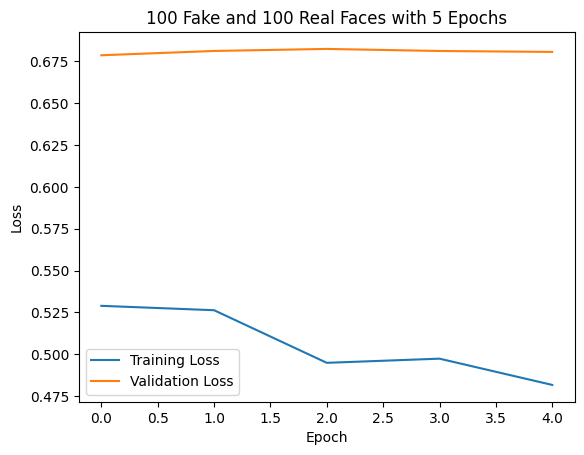

In [31]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('100 Fake and 100 Real Faces with 5 Epochs') 
plt.show()

Iterating through different values of n to find the best value

In [45]:
if not os.path.exists('logs'):
    os.mkdir('logs')

now = datetime.now()
log_name = f"log-{now.strftime('%Y-%m-%d_%H:%M')}.log"
log_file_path = os.path.join('logs', log_name)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s',handlers=[
        logging.StreamHandler(),  # Log to the console
        logging.FileHandler(log_file_path)  # Log to a file
    ])

In [46]:


def train_and_evaluate_model(n, fake_images_dir, real_images_dir, epochs=30, batch_size=32):
    logging.info(f"Training model for {n} fake and {len(os.listdir(real_images_dir))} real faces.")
    now = datetime.now()
    date_time = now.strftime("%m-%d_%H:%M")
    
    fake_files = n_random_files(n, fake_images_dir)
    real_files = n_random_files(len(os.listdir(real_images_dir)), real_images_dir)
    images, labels = load_dataset(fake_files, real_files)
    logging.info(f"Loaded {len(images)} images and {len(labels)} labels.")
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=0.3, random_state=42
    )

    train_images = tf.keras.applications.efficientnet.preprocess_input(train_images)
    val_images = tf.keras.applications.efficientnet.preprocess_input(val_images)
    logging.info("Preprocessed images.")

    base_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')  
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images, val_labels))
    logging.info("Model trained.")
    
    test_loss, test_accuracy = model.evaluate(val_images, val_labels)

    # Logging model evaluation metrics
    logging.info(f"Model Evaluation for {n} fake and {len(os.listdir(real_images_dir))} real faces:")
    logging.info(f"Test Loss: {test_loss}")
    logging.info(f"Test Accuracy: {test_accuracy}")

    # Plotting accuracies
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{n} Fake and {len(os.listdir(real_images_dir))} Real Faces with {epochs} Epochs')
    plt.legend()

    accuracies_plot_path = f'plots/accuracies/{n}_fake_{len(os.listdir(real_images_dir))}_real_faces_{epochs}_epochs_{date_time}.png'
    os.makedirs(os.path.dirname(accuracies_plot_path), exist_ok=True)
    plt.savefig(accuracies_plot_path)
    plt.close()

    # Display confusion matrix
    val_predictions = model.predict(val_images)
    val_predictions = (val_predictions > 0.5).astype(int)

    cm = confusion_matrix(val_labels, val_predictions)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'{n} Fake and {len(os.listdir(real_images_dir))} Real Faces')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    confusion_matrix_plot_path = f'plots/confusion_matrices/{n}_fake_{len(os.listdir(real_images_dir))}_real_faces_{epochs}_epochs_{date_time}.png'
    os.makedirs(os.path.dirname(confusion_matrix_plot_path), exist_ok=True)
    plt.savefig(confusion_matrix_plot_path)
    plt.close()

    # Display loss graph
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'{n} Fake and {len(os.listdir(real_images_dir))} Real Faces with {epochs} Epochs')
    losses_plot_path = f'plots/losses/{n}_fake_{len(os.listdir(real_images_dir))}_real_faces_{epochs}_epochs_{date_time}.png'
    os.makedirs(os.path.dirname(losses_plot_path), exist_ok=True)
    plt.savefig(losses_plot_path)
    plt.close()

In [47]:
# List of values for 'n'
n_list = [1000, 2000, 3000, 4000, 5000, 6000]
# n_list = [1000]
epochs = 3

# Train and evaluate models for different 'n' values
for n in n_list:
    train_and_evaluate_model(n, fake_images_dir, real_images_dir, epochs=epochs)

2024-02-21 13:29:03,059 - INFO - Training model for 1000 fake and 1201 real faces.


Epoch 1/3
49/49 [==============================] - 14s 109ms/step - loss: 0.6142 - accuracy: 0.6630 - val_loss: 0.5799 - val_accuracy: 0.7126
Epoch 2/3
49/49 [==============================] - 3s 63ms/step - loss: 0.5331 - accuracy: 0.7448 - val_loss: 0.5386 - val_accuracy: 0.7383
Epoch 3/3
21/21 [==============================] - 1s 45ms/step - loss: 0.5183 - accuracy: 0.7443


2024-02-21 13:29:55,563 - INFO - Model Evaluation for 1000 fake and 1201 real faces:
2024-02-21 13:29:55,565 - INFO - Test Loss: 0.5183479189872742
2024-02-21 13:29:55,566 - INFO - Test Accuracy: 0.7443267703056335


21/21 [==============================] - 3s 42ms/step


In [ ]:
E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-21 13:50:38.390546: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.